Late night 1 hour hack of the freshly released dataset on train time tables by IRCTC.
Source: https://data.gov.in/catalog/indian-railways-train-time-table-0#web_catalog_tabs_block_10

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [20]:
# Load the data into a dataframe
df = pd.read_csv("data/isl_wise_train_detail_03082015_v1.csv")

In [21]:
sns.set_context("poster")
# Show some rows
df.head()

,Train No.,train Name,islno,station Code,Station Name,Arrival time,Departure time,Distance,Source Station Code,source Station Name,Destination station Code,Destination Station Name
0,'00851',BNC SUVIDHA SPL,1,BBS,BHUBANESWAR,'00:00:00','22:50:00',0,BBS,BHUBANESWAR,BNC,BANGALORE CANT
1,'00851',BNC SUVIDHA SPL,2,BAM,BRAHMAPUR,'01:10:00','01:12:00',166,BBS,BHUBANESWAR,BNC,BANGALORE CANT
2,'00851',BNC SUVIDHA SPL,3,VSKP,VISAKHAPATNAM,'05:10:00','05:30:00',443,BBS,BHUBANESWAR,BNC,BANGALORE CANT
3,'00851',BNC SUVIDHA SPL,4,BZA,VIJAYAWADA JN,'11:10:00','11:20:00',793,BBS,BHUBANESWAR,BNC,BANGALORE CANT
4,'00851',BNC SUVIDHA SPL,5,RU,RENIGUNTA JN,'16:42:00','16:52:00',1169,BBS,BHUBANESWAR,BNC,BANGALORE CANT


In [4]:
df.columns

Index([u'Train No.', u'train Name', u'islno', u'station Code', u'Station Name',
       u'Arrival time', u'Departure time', u'Distance', u'Source Station Code',
       u'source Station Name', u'Destination station Code',
       u'Destination Station Name'],
      dtype='object')

In [22]:
# Convert time columns to datetime objects
df[u'Arrival time'] = pd.to_datetime(df[u'Arrival time'])
df[u'Departure time'] = pd.to_datetime(df[u'Departure time'])

In [23]:
df.head()

,Train No.,train Name,islno,station Code,Station Name,Arrival time,Departure time,Distance,Source Station Code,source Station Name,Destination station Code,Destination Station Name
0,'00851',BNC SUVIDHA SPL,1,BBS,BHUBANESWAR,2015-08-10 00:00:00,2015-08-10 22:50:00,0,BBS,BHUBANESWAR,BNC,BANGALORE CANT
1,'00851',BNC SUVIDHA SPL,2,BAM,BRAHMAPUR,2015-08-10 01:10:00,2015-08-10 01:12:00,166,BBS,BHUBANESWAR,BNC,BANGALORE CANT
2,'00851',BNC SUVIDHA SPL,3,VSKP,VISAKHAPATNAM,2015-08-10 05:10:00,2015-08-10 05:30:00,443,BBS,BHUBANESWAR,BNC,BANGALORE CANT
3,'00851',BNC SUVIDHA SPL,4,BZA,VIJAYAWADA JN,2015-08-10 11:10:00,2015-08-10 11:20:00,793,BBS,BHUBANESWAR,BNC,BANGALORE CANT
4,'00851',BNC SUVIDHA SPL,5,RU,RENIGUNTA JN,2015-08-10 16:42:00,2015-08-10 16:52:00,1169,BBS,BHUBANESWAR,BNC,BANGALORE CANT


##Distribution of Arrival and Departure Times
Lets analyze the arrival and departure time distributions. As we can see from the plots below, both the times follow as similar distribution. What is interesting is that a majority of the trains arrive during the night (which is good as Indians love to travel during night).

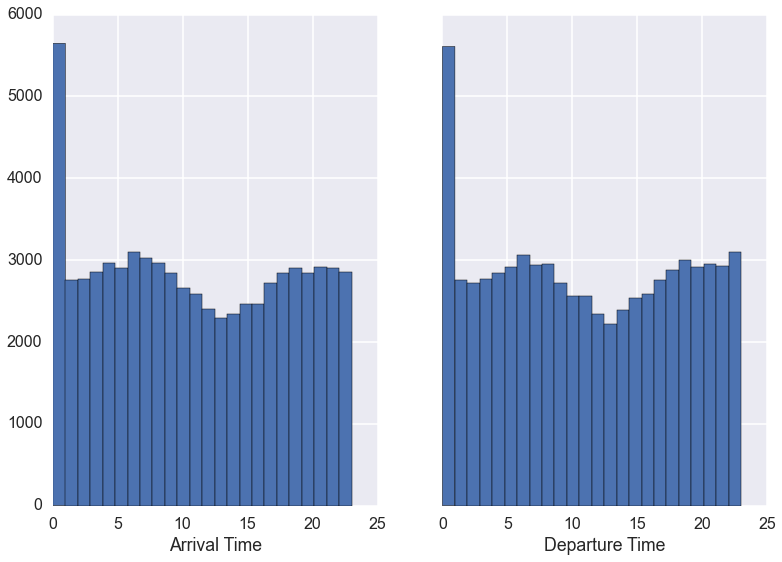

In [28]:
fig, ax = plt.subplots(1,2, sharey=True)
df[u'Arrival time'].map(lambda x: x.hour).hist(ax=ax[0], bins=24)
df[u'Departure time'].map(lambda x: x.hour).hist(ax=ax[1], bins=24)
ax[0].set_xlabel("Arrival Time")
ax[1].set_xlabel("Departure Time")

It would also be interesting to find out the distribution of the stoppage time at a station. 
$Stoppage\_time = Departure\_time - Arrival\_time$

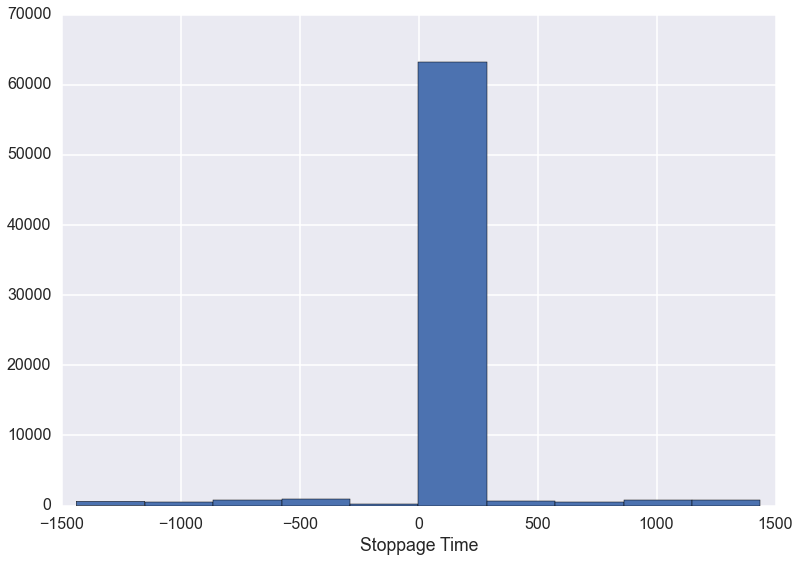

In [25]:
df["Stoppage"] = (df[u'Departure time'] - df[u'Arrival time']).astype('timedelta64[m]') # Find stoppage time in minutes
# Plot distribution of stoppage time
df["Stoppage"].hist()
plt.xlabel("Stoppage Time")

This looks wierd. Stoppage time cannot be negative or more than 500 minutes (~8 hours). Let us remove these outlires and plot our distributions again. 

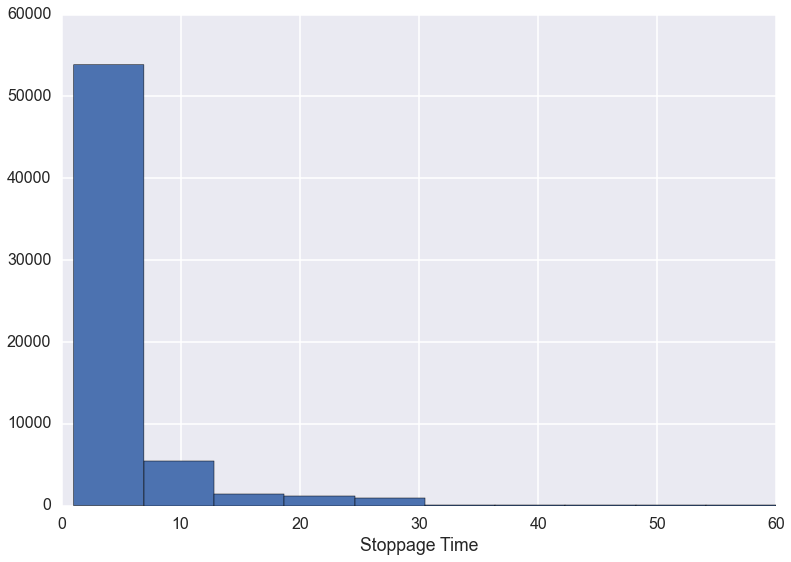

In [26]:
df["Stoppage"][(df["Stoppage"]> 0) & (df["Stoppage"] < 61)].hist() # Let us take that max stoppage time can be an hour. 
plt.xlabel("Stoppage Time")

This is better but still appears that most stoppage times are less than 30 minutes. So let us plot again in that range. 

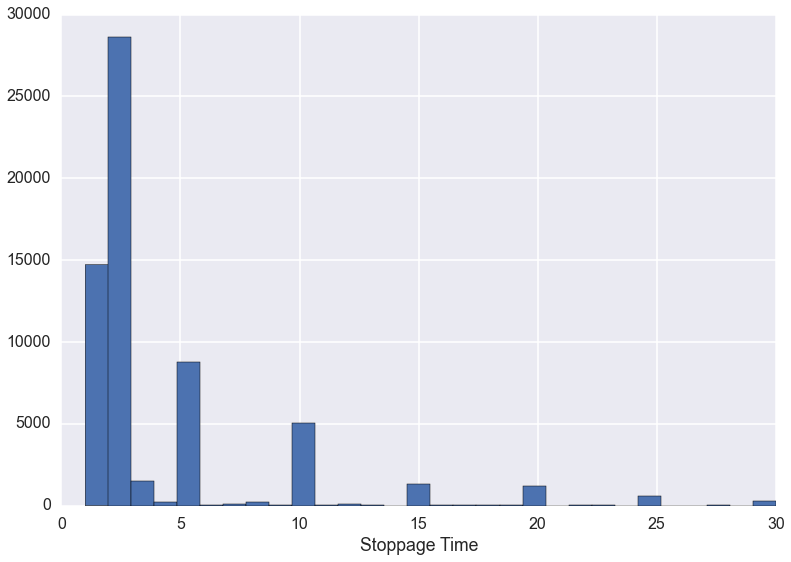

In [27]:
df["Stoppage"][(df["Stoppage"]> 0) & (df["Stoppage"] < 31)].hist(bins=30) # Let us take that max stoppage time can be an hour. 
plt.xlabel("Stoppage Time")

This is more informative. We see that most stoppage times are either 1 or 2 minutes or a multiple of 5 minutes. Makes a lot of sense. Now let us look filter the data to make it consist of the stoppage time in this range. 

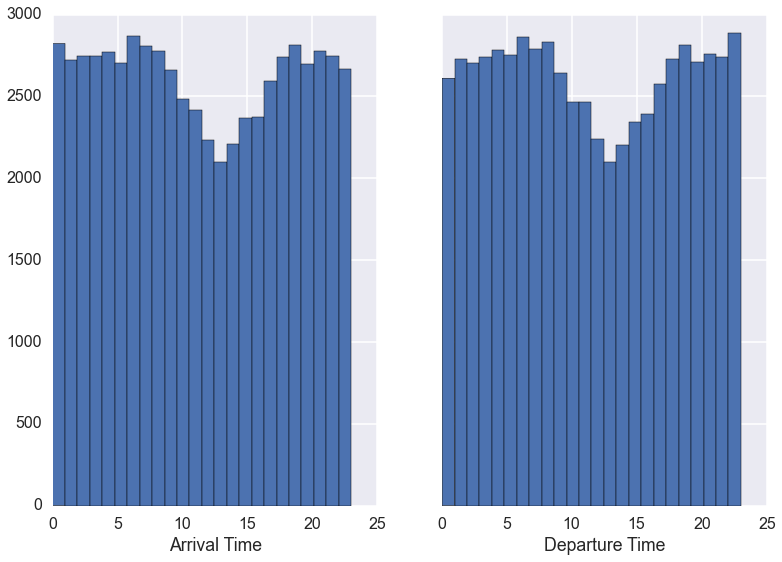

In [29]:
df_stoppage_30 = df[(df["Stoppage"]> 0) & (df["Stoppage"] < 31)] # Filter data between nice stoppage times
# Plot data for this stoppage time range.
fig, ax = plt.subplots(1,2, sharey=True)
df_stoppage_30[u'Arrival time'].map(lambda x: x.hour).hist(ax=ax[0], bins=24)
df_stoppage_30[u'Departure time'].map(lambda x: x.hour).hist(ax=ax[1], bins=24)
ax[0].set_xlabel("Arrival Time")
ax[1].set_xlabel("Departure Time")

Aah, it looks like less trains arrive and depart during lunch hours around 1200-1500 Hours. Looks wierd but can also point to the fact that many trains run at night and travel short distances. This makes me think that we should look closely at the total distance per train. 

## Distance analysis

Lets now analyze the total distance travelled by a train. This can be easily found by using the last value for each train. 

In [34]:
# Total Number of stations of the train, last arrival time, first departure time, last distance, first station and last station.

df_train_dist = df[[u'Train No.', u'station Code', u'Arrival time', u'Departure time',
                    u'Distance', u'Source Station Code', u'Destination station Code']]\
.groupby(u'Train No.').agg({u'station Code': "count", u'Arrival time': "last",
                                                               u'Departure time': "first", u'Distance': "last",
                                                               u'Source Station Code': "first", u'Destination station Code': "last"})

In [48]:
df_train_dist.head()

,Distance,station Code,Source Station Code,Destination station Code,Arrival time,Departure time
Train No.,,,,,,
'00851',1511,7,BBS,BNC,2015-08-10 22:40:00,2015-08-10 22:50:00
'00852',1511,7,BNC,BBS,2015-08-10 01:45:00,2015-08-10 01:00:00
'01081',436,8,DR,BSL,2015-08-10 05:00:00,2015-08-10 21:45:00
'01082',436,8,BSL,DR,2015-08-10 16:20:00,2015-08-10 08:35:00
'01149',117,4,BSL,CSN,2015-08-10 21:30:00,2015-08-10 18:35:00


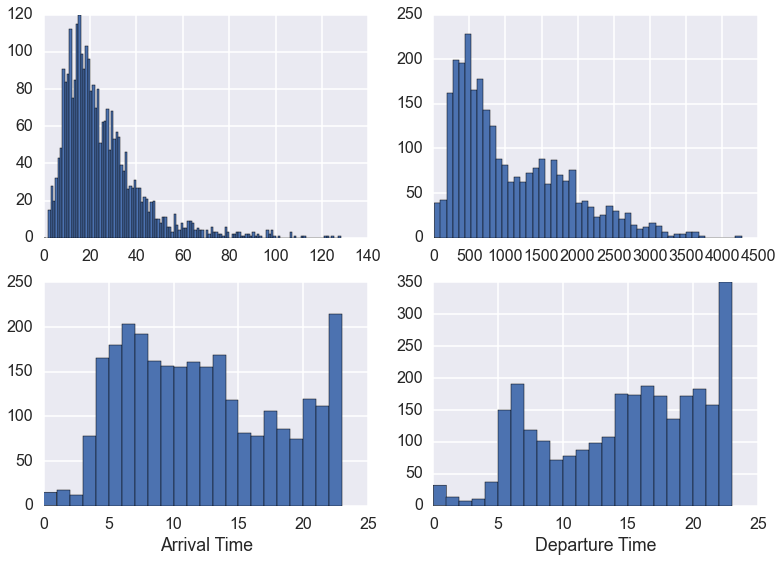

In [40]:
# Let us plot the distribution of the distances as well as station codes, as well as arrival and departure times
fig, ax = plt.subplots(2,2)
df_train_dist[u'station Code'].hist(ax=ax[0][0], bins=range(df_train_dist[u'station Code'].max() + 1))
df_train_dist[u'Distance'].hist(ax=ax[0][1], bins=50)
ax[1][0].set_xlabel("Total Stations stopped")
ax[1][1].set_xlabel("Total Distance covered")

df_train_dist[u'Arrival time'].map(lambda x: x.hour).hist(ax=ax[1][0], bins=range(24))
df_train_dist[u'Departure time'].map(lambda x: x.hour).hist(ax=ax[1][1], bins=range(24))
ax[1][0].set_xlabel("Arrival Time")
ax[1][1].set_xlabel("Departure Time")

## Train specific analysis
Ok this is insteresting. 

* We observe that majority of the trains cover 15-25 stations. 
* We also see that many trains are short distance trains travelling only 500-700 Kilometers. 
* Arrival time for many trains at their last stop is mostly during morning 0500 to afternoon 1300 hours and also a lot around midnight. 
* Departure time for a majority of the trains is actually mostly during night. 

Now the question is: Do trains on average having more stops run longer distance or not ? Let us try to answer this question.  



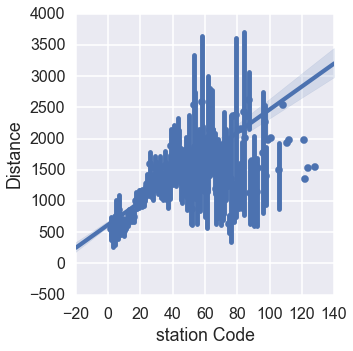

In [41]:
sns.lmplot(x=u'station Code', y=u'Distance', data=df_train_dist, x_estimator=np.mean)

The regression plot shows that we cannot draw any conclusion regarding the relation between number of stopns and distance. We do see that low stops mean small distances but for larger distances we observe that this condition doesn't hold true. This can be attributed to the availability of both express as well as passenger trains for longer distances.

In [49]:
# Lets us see what are some general statistics of the distances and the number of stops. 
df_train_dist.describe()

,Distance,station Code
count,2810.000000,2810.000000
mean,1073.904270,24.557295
std,770.358422,16.903673
min,14.000000,2.000000
25%,463.500000,13.000000
50%,810.000000,20.000000
75%,1585.000000,31.000000
max,4273.000000,128.000000


We observe that 50% of the trains travel less than 810 Km as well as have less than 20 stops. Maximum distance travelled by a train is 4273 Km and maximum stoppages are 128, both of which are very high numbers. 

## Analysis of Stations

Let us look at which stations are popular. 


In [56]:
df[[u'Train No.', u'Station Name']].groupby(u'Station Name').count().sort(u'Train No.', ascending=False).head(20)

,Train No.
Station Name,
VIJAYAWADA JN,313
VADODARA JN,298
KANPUR CENTRAL,283
SURAT,267
ITARSI JN,262
AHMEDABAD JN,255
KALYAN JN,254
BHUSAVAL JN,248
NAGPUR,243


Looks like Vijaywada is the station where maximum trains have a stoppage. I am upset not to see my place Allahabad in the top 20 list. Neverthless, let us plot the distribution of these stoppages. 

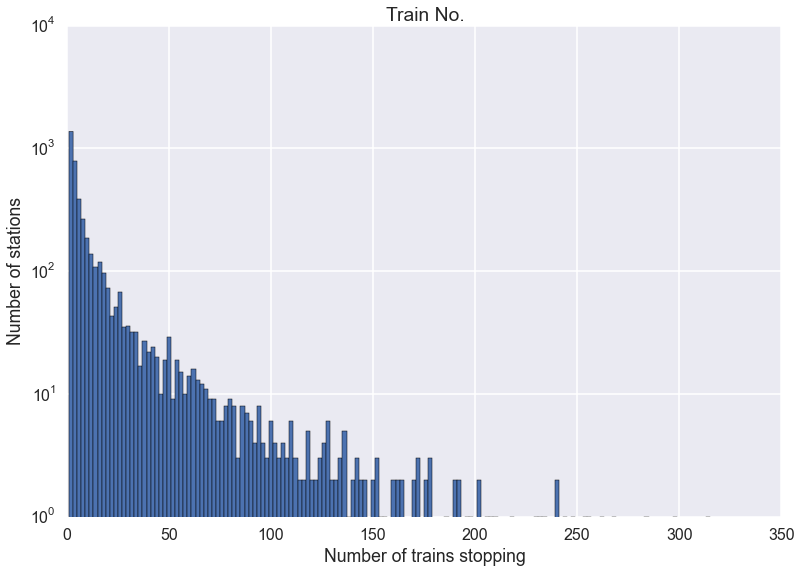

In [66]:
df[[u'Train No.', u'Station Name']].groupby(u'Station Name').count().hist(bins=range(1,320,2), log=True)
plt.xlabel("Number of trains stopping")
plt.ylabel("Number of stations")

Looks like very few stations have a high volume of trains stopping. Most stations see close to 5 trains. 
Let us now look at some train statistics like:
    
* Trains with maximum stops, I would personally avoid these trains. 
* Trains which travel maximum distance, if they take less stops I would prefer these.

In [67]:
df_train_dist.sort(u'station Code', ascending=False).head(10) # Top 10 trains with maximum number of stops

,Distance,station Code,Source Station Code,Destination station Code,Arrival time,Departure time
Train No.,,,,,,
'59386',1545,128,CWA,INDB,2015-08-10 08:10:00,2015-08-10 01:20:00
'13131',1532,124,KOAA,ANVT,2015-08-10 11:40:00,2015-08-10 19:50:00
'11039',1346,122,KOP,G,2015-08-10 20:15:00,2015-08-10 13:35:00
'13008',1978,121,SGNR,HWH,2015-08-10 19:30:00,2015-08-10 23:50:00
'13007',1978,112,HWH,SGNR,2015-08-10 07:00:00,2015-08-10 09:35:00
'13049',1922,111,HWH,ASR,2015-08-10 10:15:00,2015-08-10 13:50:00
'13352',2536,108,ALLP,DHN,2015-08-10 13:15:00,2015-08-10 06:00:00
'15018',1713,106,GKP,LTT,2015-08-10 18:05:00,2015-08-10 17:50:00
'58112',878,106,ITR,TATA,2015-08-10 00:05:00,2015-08-10 21:30:00


In [68]:
df_train_dist.sort(u'Distance', ascending=False).head(10) # Top 10 trains with maximum distance

,Distance,station Code,Source Station Code,Destination station Code,Arrival time,Departure time
Train No.,,,,,,
'15906',4273,62,DBRG,CAPE,2015-08-10 09:50:00,2015-08-10 23:45:00
'15905',4273,62,CAPE,DBRG,2015-08-10 07:15:00,2015-08-10 23:00:00
'16318',3715,84,JAT,CAPE,2015-08-10 21:30:00,2015-08-10 09:05:00
'16317',3714,72,CAPE,JAT,2015-08-10 13:10:00,2015-08-10 14:10:00
'06336',3650,58,KCVL,GHY,2015-08-10 08:15:00,2015-08-10 12:00:00
'06335',3650,58,GHY,KCVL,2015-08-10 22:30:00,2015-08-10 23:25:00
'16688',3609,79,JAT,MAQ,2015-08-10 22:45:00,2015-08-10 13:40:00
'16687',3607,63,MAQ,JAT,2015-08-10 13:10:00,2015-08-10 16:50:00
'12483',3597,26,KCVL,ASR,2015-08-10 22:20:00,2015-08-10 09:20:00


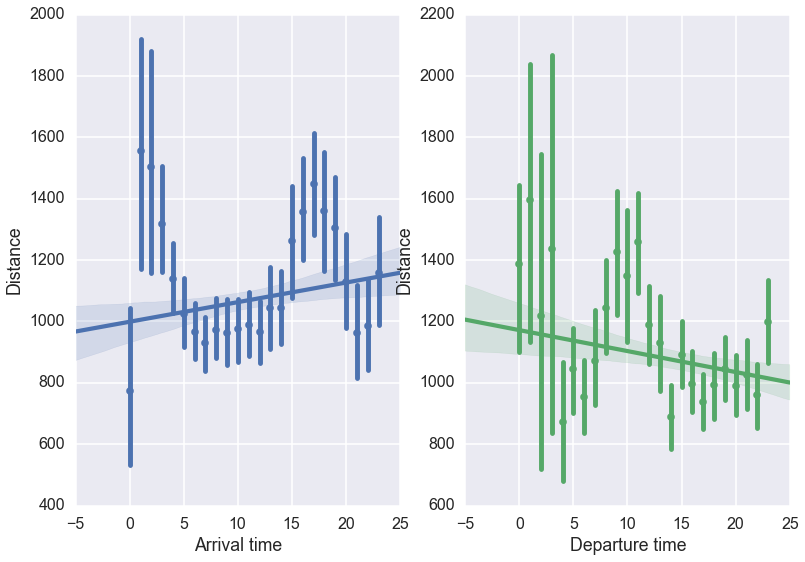

In [73]:
fig, ax = plt.subplots(1,2)
sns.regplot(x=df_train_dist[u'Arrival time'].map(lambda x: x.hour), y=df_train_dist[u'Distance'], x_estimator=np.mean, ax=ax[0])
sns.regplot(x=df_train_dist[u'Departure time'].map(lambda x: x.hour), y=df_train_dist[u'Distance'], x_estimator=np.mean, ax=ax[1])

We see that departure and arrival time of a lot of long distance trains is during night around 0000 Hours, many long route trains arrive during late afternoons around 1500 hours and many long route trains leave early morning around 1000 Hours as well. Most medium distance trains arrive during the day